In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-22 11:02:21.491694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 11:02:21.491758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_23043 = pd.read_csv("../data/datasets_by_whale/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]] 
#whale with largest route

### Split data for train and test 

In [3]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    test_df = df[int(n*0.7):]

    num_features = df.shape[1]
    
    return train_df,test_df

In [4]:
train_df,test_df = split_data(df_23043)

### Create data windows 

In [5]:
def data_windowing(train_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

    return window_train, window_test

In [6]:
window_train,window_test = data_windowing(train_df,test_df)

2021-10-22 11:02:25.408904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-22 11:02:25.408949: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-22 11:02:25.409056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-22 11:02:25.410310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Splits windows in X,y

In [7]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2] # X= features; y = labels(the next coordenate point)
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [8]:
train = window_train.map(data_map)
test = window_test.map(data_map)

### Trainning a neural network model

In [9]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

In [10]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.0005),metrics=[tf.metrics.MeanAbsoluteError()])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=100,
                         validation_data=test,
                         callbacks=[early_stopping, tensorboard_callback])


2021-10-22 11:02:25.604774: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-22 11:02:25.604817: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-22 11:02:25.608047: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-22 11:02:25.676183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
3/9 [=========>....................] - ETA: 0s - loss: 7730.6665 - mean_absolute_error: 76.8411

2021-10-22 11:02:27.329888: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-22 11:02:27.329931: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-22 11:02:27.349073: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-22 11:02:27.358138: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-22 11:02:27.397074: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_22_11_02_27

2021-10-22 11:02:27.411969: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_22_11_02_27/DESKTOP-R3AGIN3.trace.json.gz
2021-10-22 11:02:27.432644: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_22_11_02_27

2021-10-22 11:02:27.

9/9 [==============================] - 2s 80ms/step - loss: 7869.5493 - mean_absolute_error: 77.6996 - val_loss: 7225.2065 - val_mean_absolute_error: 72.3696
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 7739.6743 - mean_absolute_error: 76.8817 - val_loss: 7100.6108 - val_mean_absolute_error: 71.5356
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 7577.3564 - mean_absolute_error: 75.8432 - val_loss: 6944.8633 - val_mean_absolute_error: 70.5823
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 7389.3599 - mean_absolute_error: 74.7829 - val_loss: 6763.6445 - val_mean_absolute_error: 69.5371
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 7147.5444 - mean_absolute_error: 73.4476 - val_loss: 6467.3857 - val_mean_absolute_error: 67.7782
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 6854.2925 - mean_absolute_error: 71.7709 - val_loss: 6203.9121 - val_mean_absolute_error: 

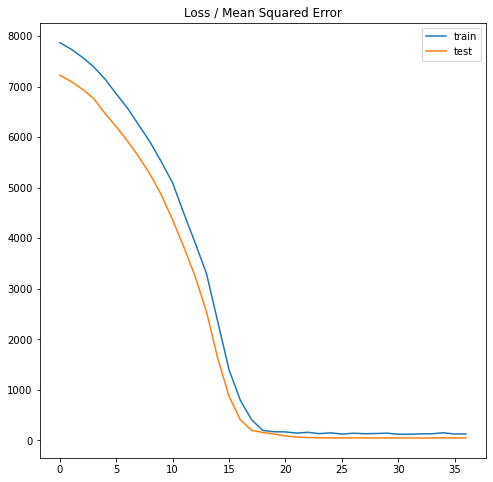

In [12]:
pyplot.figure(figsize=(8,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
test_df[:21]

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [14]:
np.array([list(test.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [15]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [16]:
y_pred = lstm_model.predict(np.array([test_df[:20]]))[0]

In [17]:
y_pred

array([-119.40815,   34.82724], dtype=float32)

In [18]:
test_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

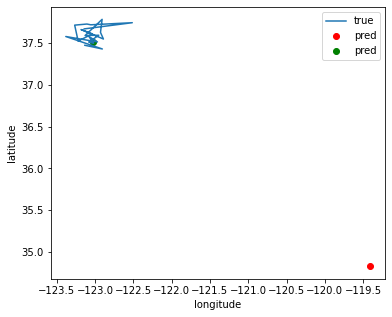

In [20]:
pyplot.figure(figsize=(6,5))
pyplot.plot(test_df[:20]["location-long"], test_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(test_df.iloc[21][0], test_df.iloc[21][1],  c="green", label='pred')
pyplot.xlabel("longitude")
pyplot.ylabel("latitude")
pyplot.legend()
pyplot.show()

### Predicting a new route

In [57]:
n = 20
points = np.array([test_df[:n]])[0]
route_predict = pd.DataFrame()

for i in points:
    n = n+1
print(n)
print(points)
r_predict=lstm_model.predict(points)
route_predict = route_predict.append(r_predict)
truth = test_df.iloc[n]
print(truth)


40
[[-123.14    37.667]
 [-122.513   37.741]
 [-123.055   37.716]
 [-123.105   37.725]
 [-123.265   37.712]
 [-123.22    37.522]
 [-123.032   37.607]
 [-123.182   37.659]
 [-122.89    37.546]
 [-122.928   37.625]
 [-122.907   37.781]
 [-123.129   37.588]
 [-122.951   37.591]
 [-123.081   37.509]
 [-123.017   37.495]
 [-123.08    37.577]
 [-122.968   37.511]
 [-123.381   37.576]
 [-122.904   37.427]
 [-123.132   37.471]]


ValueError: in user code:

    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/silvia/miniconda3/envs/animal_movement/lib/python3.9/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)
